## Logistic Regression Model Comparisons - Lab

## Introduction

In this lab, you'll further investigate how to tune your personal logistic regression implementation, as well as that of sci-kit learn in order to produce better models.

## Objectives

* Understand and implement logistic regression
* Compare logistic model outputs

In the previous lab, you were able to verify your manual logistic regression model output using sci-kit learn. However, that model did not include an intercept or any regularization. In this investigative lab, you will analyze the impact these two tuning parameters.

## Importing the Data

As with the previous lab, import the dataset stored in **heart.csv**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.708333,1.0,1.000000,0.481132,0.244292,1.0,0.0,0.603053,0.0,0.370968,0.0,0.0,0.333333,1.0
1,0.166667,1.0,0.666667,0.339623,0.283105,0.0,0.5,0.885496,0.0,0.564516,0.0,0.0,0.666667,1.0
2,0.250000,0.0,0.333333,0.339623,0.178082,0.0,0.0,0.770992,0.0,0.225806,1.0,0.0,0.666667,1.0
3,0.562500,1.0,0.333333,0.245283,0.251142,0.0,0.5,0.816794,0.0,0.129032,1.0,0.0,0.666667,1.0
4,0.583333,0.0,0.000000,0.245283,0.520548,0.0,0.5,0.702290,1.0,0.096774,1.0,0.0,0.666667,1.0


## Problem Formulation

Define X and y as with the previous lab. This time, follow best practices and also implement a standard train-test split.  
**For consistency of results, use random_state=17.**

In [3]:
X = df[df.columns[:-1]]
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)

## Initial Model - Personal Implementation

Use your code from the previous lab to once again train a logistic regression algorithm on the training set.

In [4]:
def sigmoid(x):
    x = np.array(x)
    return 1/(1 + np.e**(-1*x))

In [5]:
def grad_desc(X, y, max_iterations, alpha, initial_weights=None):
    """Be sure to set default behavior for the initial_weights parameter."""
    if initial_weights == None:
        initial_weights = np.ones((X.shape[1],1)).flatten()
    weights = initial_weights
    training_errors = []
    #Create a for loop of iterations
    for iteration in range(max_iterations):
        #Generate predictions using the current feature weights
        predictions = sigmoid(np.dot(X,weights))
        #Calculate an error vector based on these initial predictions and the correct labels
        error_vector = y - predictions
        #Calculate the gradient (transpose of X times error is the gradient)
        gradient = np.dot(X.transpose(),error_vector)
        #Update the weight vector take a step of alpha in direction of gradient 
        weights += alpha * gradient
        training_errors.append(np.abs(error_vector).sum())
    #Return finalized Weights
    return weights, training_errors

In [6]:
weights, errors = grad_desc(X_train, y_train, 10**4, .001)

## Now use your algorithm to make [probability] predictions on the test set

In [7]:
y_hat_test = sigmoid(np.dot(X_test, weights))

## Create an ROC curve for your predictions

In [8]:
fpr, tpr, thresholds = roc_curve(y_test, y_hat_test)

AUC: 0.8982578397212544


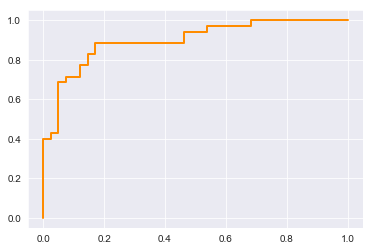

In [9]:
print('AUC: {}'.format(auc(fpr, tpr)))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve');

## Update your ROC curve to not only include a graph of the test set, but one of the train set

In [10]:
y_hat_train = sigmoid(np.dot(X_train, weights))
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_hat_test)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_hat_train)

test_AUC: 0.8982578397212544
train_AUC: 0.9287866772402855


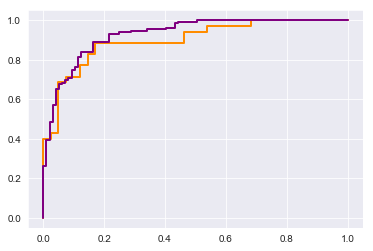

In [11]:
print('test_AUC: {}'.format(auc(test_fpr, test_tpr)))
plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=2, label='ROC curve');
print('train_AUC: {}'.format(auc(train_fpr, train_tpr)))
plt.plot(train_fpr, train_tpr, color='purple',
         lw=2, label='ROC curve');

## Create a confusion matrix for your predictions

Use a standard decision boundary of .5 to convert your probabilities output by logistic regression into binary classifications. (Again this should be for the test set.) Afterwards, feel free to use the built in sci-kit learn methods to compute the confusion matrix as we discussed in previous sections.

In [12]:
def get_labels(y_pred, thresh=0.50):
    labels = [1 if j > thresh else 0 for j in y_pred]
    return labels

In [13]:
labels = get_labels(y_hat_test)
cm = confusion_matrix(y_test, labels)

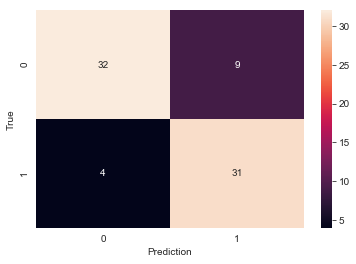

In [16]:
sns.heatmap(cm, annot=True);
plt.xlabel('Prediction')
plt.ylabel('True');

## Initial Model - sci-kit learn

Do the same using the built in method from sci-kit learn. To start, create an identical model as you did in the last section; turn off the intercept and set the regularization parameter, C, to a ridiculously large number such as 1e16. 

In [17]:
logreg = LogisticRegression(fit_intercept=False, C=1e16, solver='lbfgs')
model_log = logreg.fit(X_train, y_train)
model_log

LogisticRegression(C=1e+16, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [18]:
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

## Create an ROC Curve for the sci-kit learn model

In [19]:
def make_roc_curve(X, y, decision_function, test):
    y_score = logreg.fit(X, y).decision_function(decision_function)
    fpr, tpr, thresholds = roc_curve(test, y_score)
    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.plot(fpr, tpr, lw=2, label='ROC curve');
    return fpr, tpr

AUC: 0.8996515679442508


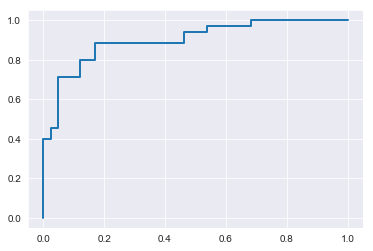

In [20]:
test_fpr, test_tpr = make_roc_curve(X_train, y_train, X_test, y_test)

## As before add an ROC curve to the graph for the train set as well

AUC: 0.7953211736716892


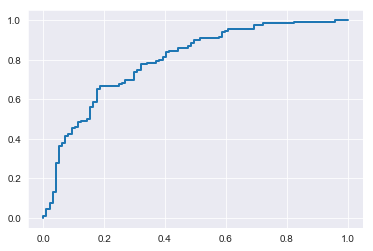

In [21]:
roc_train = make_roc_curve(X_test, y_test, X_train, y_train)

Text(34.0, 0.5, 'True')

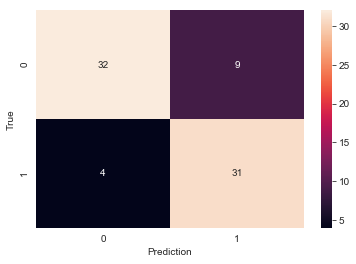

In [22]:
cm = confusion_matrix(y_test, y_hat_test)
sns.heatmap(cm, annot=True);
plt.xlabel('Prediction')
plt.ylabel('True')

## Adding an Intercept

Now add an intercept to the sci-kit learn model. Keep the regularization parameter C set to a very large number such as 1e16. Plot all three models ROC curves on the same graph.

In [23]:
logregint = LogisticRegression(fit_intercept=True, C=1e16, solver='lbfgs')
model_log = logregint.fit(X_train, y_train)
model_log

LogisticRegression(C=1e+16, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [26]:
y_hat_test_intercept = logregint.decision_function(X_test)
intercept_fpr, intercept_tpr, intercept_threshold = roc_curve(y_test, y_hat_test_intercept)

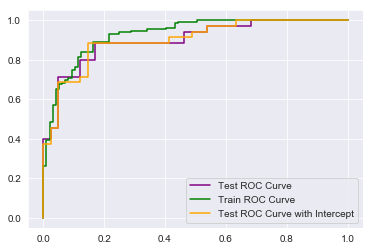

In [27]:
plt.plot(test_fpr, test_tpr, label="Test ROC Curve", color='purple')
plt.plot(train_fpr, train_tpr, label="Train ROC Curve", color='green')
plt.plot(intercept_fpr, intercept_tpr, label="Test ROC Curve with Intercept", color='orange')
plt.legend();

## Altering the Regularization Parameter

Now, experiment with altering the regularization parameter. At minimum, create 5 different subplots with varying regularization (C) parameters. For each, plot the ROC curve of the train and test set for that specific model.  

Regularization parameters between 1 and 20 are recommended. Observe the difference in test and train AUC as you go along.

Test AUC with C=1.5^0: 0.9059233449477352
Train AUCwith C=1.5^0: 0.9250594766058683
Test AUC with C=1.5^1: 0.9038327526132404
Train AUCwith C=1.5^1: 0.9268041237113402
Test AUC with C=1.5^2: 0.9045296167247387
Train AUCwith C=1.5^2: 0.927755749405234
Test AUC with C=1.5^3: 0.9059233449477352
Train AUCwith C=1.5^3: 0.9291831879460746
Test AUC with C=1.5^4: 0.9059233449477352
Train AUCwith C=1.5^4: 0.9306106264869152
Test AUC with C=1.5^5: 0.9038327526132404
Train AUCwith C=1.5^5: 0.9313243457573355
Test AUC with C=1.5^6: 0.9024390243902439
Train AUCwith C=1.5^6: 0.931958762886598
Test AUC with C=1.5^7: 0.9003484320557491
Train AUCwith C=1.5^7: 0.9324345757335448


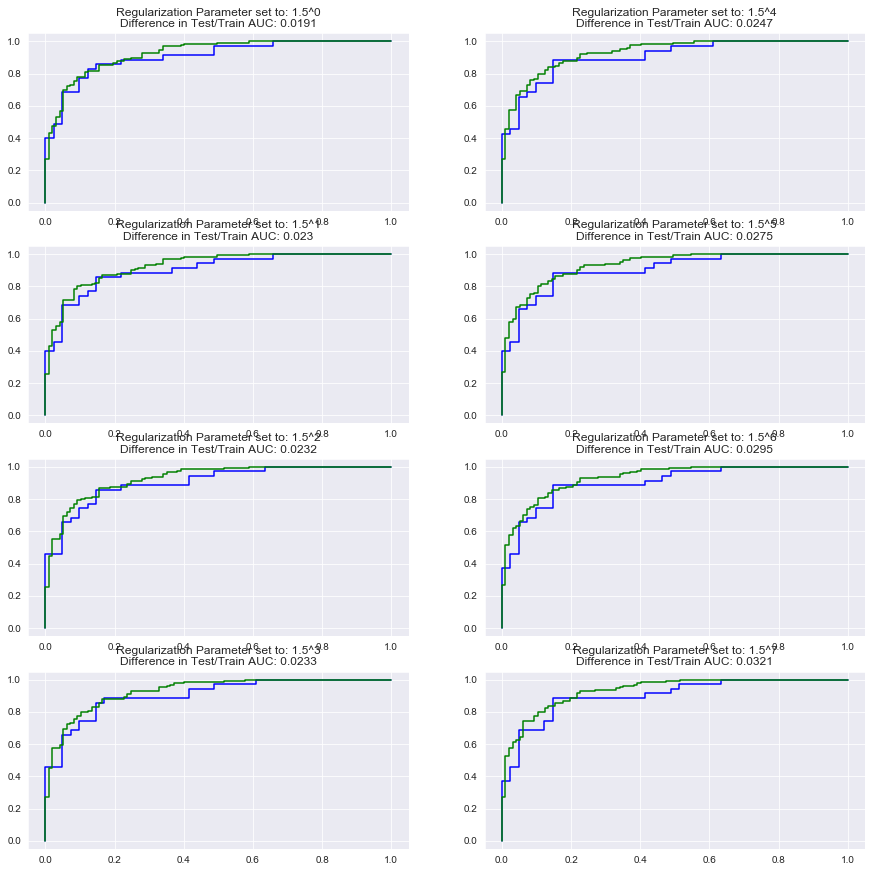

In [28]:
fig, axes = plt.subplots(4, 2, figsize=(15,15))
for c in range(8):
    i = c%4
    j = c//4
    ax = axes[i,j]
    logreg = LogisticRegression(fit_intercept=True, C=1.5**c, solver='lbfgs')
    logreg.fit(X_train, y_train)
    y_test_score = logreg.decision_function(X_test)
    y_train_score = logreg.decision_function(X_train)
    test_fpr, test_tpr, test_threshold = roc_curve(y_test, y_test_score)
    train_fpr, train_tpr, train_threshold = roc_curve(y_train, y_train_score)
    test_auc = auc(test_fpr, test_tpr)
    train_auc = auc(train_fpr, train_tpr)
    auc_diff = round(train_auc - test_auc, 4)
    print('Test AUC with C=1.5^{}: {}'.format(c, auc(test_fpr, test_tpr)))
    print('Train AUCwith C=1.5^{}: {}'.format(c, auc(train_fpr, train_tpr)))
    ax.plot(test_fpr, test_tpr, label='Test ROC Curve, C=1.5^{}'.format(c), color='blue')
    ax.plot(train_fpr, train_tpr, label='Train ROC Curve, C=1.5^{}'.format(c), color='green')
    ax.set_title('Regularization Parameter set to: 1.5^{}\nDifference in Test/Train AUC: {}'.format(c, auc_diff))

## Comment on how the Regularization Parameter Impacts the ROC curves plotted above

As C increases, the difference in the AUC of the test and train ROC curves increases.

## Summary

In this lab, you reviewed many of the accuracy measures for classification algorithms and observed the impact of additional tuning models using intercepts and regularization.